In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


seed = 42

np.random.seed(seed)
torch.manual_seed(seed)

In [16]:
with open("data_3000_points.txt") as f:
    data = f.readlines()

for i in range(len(data)):
    data[i] = data[i].split()
    data[i] = [float(x) for x in data[i]]
    
data = np.array(data)

print(data.shape)

(3000, 20)


In [17]:

ratio_test_val_train = 0.20

X_train, X_temp, y_train, y_temp = train_test_split(data[:, 0:3], data[:, 3:], test_size=ratio_test_val_train, random_state=seed+50)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed+50)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_train)
y_scaled = scaler_Y.fit_transform(y_train)

(2400, 3) (2400, 17)
(300, 3) (300, 17)


In [18]:

class LTPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


dataset = LTPDataset(X_scaled, y_scaled)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

X_val_scaled = scaler_X.transform(X_val)
y_val_scaled = scaler_Y.transform(y_val)

val_dataset = LTPDataset(X_val_scaled, y_val_scaled)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

X_scaled_test = scaler_X.transform(X_test)
y_scaled_test = scaler_Y.transform(y_test)

test_dataset = LTPDataset(X_scaled_test, y_scaled_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(X_scaled.shape, y_scaled.shape)
print(X_scaled_test.shape, y_scaled_test.shape)

(2400, 3) (2400, 17)
(300, 3) (300, 17)


In [19]:
class SharedBackbone(nn.Module):
    def __init__(self, input_dim, shared_dim):
        super(SharedBackbone, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, shared_dim), 
            nn.ReLU(),
            nn.Linear(shared_dim, shared_dim),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.net(x)



class AutoregressiveHead(nn.Module):
    def __init__(self, shared_dim, prev_dim, hidden_dim, dropout_rate=0.1):
        super(AutoregressiveHead, self).__init__()
        self.prev_dim = prev_dim
        
        # The input dimension for the MLP is shared features + previous outputs (if any)
        mlp_input_dim = shared_dim + prev_dim
        self.mlp = nn.Sequential(
            nn.Linear(mlp_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )
        # Residual connection: project shared features to one output.
        self.skip = nn.Linear(shared_dim, 1)
        

    def forward(self, f, prev_y):
        # If previous outputs exist, concatenate them with f.
        if self.prev_dim > 0 and prev_y is not None:
            combined_input = torch.cat([f, prev_y], dim=1)
        else:
            combined_input = f

        mlp_out = self.mlp(combined_input)
        skip_out = self.skip(f)
        y_i_pred = mlp_out + skip_out  # Residual connection
        return y_i_pred



class AutoregressiveModelWithSharedBackbone(nn.Module):
    def __init__(self, input_dim, output_dim, shared_dim, head_hidden_dim, dropout_rate=0.1):
        super(AutoregressiveModelWithSharedBackbone, self).__init__()
        self.shared_backbone = SharedBackbone(input_dim, shared_dim)
        self.output_dim = output_dim
        
        # Create autoregressive heads.
        self.heads = nn.ModuleList()
        for i in range(output_dim):
            self.heads.append(
                AutoregressiveHead(shared_dim, prev_dim=i, hidden_dim=head_hidden_dim, dropout_rate=dropout_rate)
            )

    def forward(self, x, y_true=None, teacher_forcing_ratio=1.0):
        
        batch_size = x.size(0)
        f = self.shared_backbone(x)
        y_preds = []
        aux_outputs = []
        
        for i, head in enumerate(self.heads):
            if i == 0:
                prev_y = None
            else:
                prev_list = []
                for j in range(i):
                    if y_true is not None and self.training:
                        # For each previous output, decide whether to use ground truth or model prediction.
                        use_gt = torch.rand(batch_size, 1, device=x.device) < teacher_forcing_ratio
                        prev_val = torch.where(use_gt, y_true[:, j:j+1], y_preds[j])
                    else:
                        prev_val = y_preds[j]
                    prev_list.append(prev_val)
                
                prev_y = torch.cat(prev_list, dim=1)
                
            y_i_pred = head(f, prev_y)
            aux_outputs.append(y_i_pred)
            
            y_preds.append(y_i_pred)
            
            
        y_base = torch.cat(y_preds, dim=1)
        return y_base, aux_outputs


In [20]:
class CorrectionNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        
        super(CorrectionNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + output_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x, y_base):
        combined = torch.cat([x, y_base], dim=1)
        correction = self.net(combined)
        return correction


class AutoregressiveWithCorrectionModel(nn.Module):
    def __init__(self, input_dim, output_dim, shared_dim, head_hidden_dim, correction_hidden_dim, dropout_rate=0.1):
        
        super(AutoregressiveWithCorrectionModel, self).__init__()
        self.auto_model = AutoregressiveModelWithSharedBackbone(input_dim, output_dim, shared_dim, head_hidden_dim, dropout_rate)
        self.correction_net = CorrectionNet(input_dim, output_dim, correction_hidden_dim)
    
    
    def forward(self, x, y_true=None, teacher_forcing_ratio=1.0):
        # Base autoregressive prediction.
        y_base, aux_outputs  = self.auto_model(x, y_true, teacher_forcing_ratio)
        # Correction step.
        correction = self.correction_net(x, y_base)
        y_final = y_base + correction
        return y_final , aux_outputs


In [21]:

input_dim = 3
output_dim = 17
shared_dim = 32
head_hidden_dim = 32
correction_hidden_dim = 32
dropout_rate = 0.1


model = AutoregressiveWithCorrectionModel(input_dim, output_dim, shared_dim, head_hidden_dim, correction_hidden_dim, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
initial_teacher_forcing_ratio = 1.0
final_teacher_forcing_ratio = 0.5
num_epochs = 500

aux_loss_weight = 0.5

model.train()

for epoch in range(num_epochs):
    
    # # Linearly decay teacher forcing ratio from initial to final over epochs.
        # teacher_forcing_ratio = initial_teacher_forcing_ratio - \
        #     (initial_teacher_forcing_ratio - final_teacher_forcing_ratio) * (epoch / num_epochs)

    # # Cosine decay of teacher forcing ratio from initial to final over epochs.
    teacher_forcing_ratio = final_teacher_forcing_ratio + 0.5 * (initial_teacher_forcing_ratio - final_teacher_forcing_ratio) * \
                              (1 + np.cos(np.pi * epoch / num_epochs))
    
    model.train()
    for i, (x, y_true) in enumerate(dataloader):
        
        optimizer.zero_grad()
        
        # Forward pass: get refined prediction and auxiliary outputs.
        y_pred_refined, aux_outputs = model(x, y_true, teacher_forcing_ratio)


        main_loss = criterion(y_pred_refined, y_true)

        # Compute auxiliary losses for each intermediate y prediction.
        aux_loss = 0
        for i, aux_pred in enumerate(aux_outputs):
            # Only compute auxiliary loss for the i-th output component.
            aux_loss += criterion(aux_pred, y_true[:, i:i+1])
        aux_loss = aux_loss / output_dim  # Average auxiliary loss

        # Total loss: combine main and auxiliary losses.
        loss = main_loss + aux_loss_weight * aux_loss

        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {loss.item():.4f}, "
            f"Main Loss: {main_loss.item():.4f}, Aux Loss: {aux_loss.item():.4f}, "
            f"Teacher Forcing Ratio: {teacher_forcing_ratio:.2f}")


    if (epoch+1) % 10 == 0:
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x_val, y_val_true in val_dataloader:
                y_val_pred_refined, _ = model(x_val)
                val_loss += criterion(y_val_pred_refined, y_val_true).item()
        val_loss /= len(val_dataloader)
        print(f"Validation Loss after epoch {epoch+1}: {val_loss:.4f}")
        x


Epoch [10/500], Total Loss: 0.0202, Main Loss: 0.0097, Aux Loss: 0.0209, Teacher Forcing Ratio: 1.00
Validation Loss after epoch 10: 0.0963
Epoch [20/500], Total Loss: 0.0096, Main Loss: 0.0051, Aux Loss: 0.0090, Teacher Forcing Ratio: 1.00
Validation Loss after epoch 20: 0.0632
Epoch [30/500], Total Loss: 0.0050, Main Loss: 0.0031, Aux Loss: 0.0039, Teacher Forcing Ratio: 1.00
Validation Loss after epoch 30: 0.0333
Epoch [40/500], Total Loss: 0.0066, Main Loss: 0.0027, Aux Loss: 0.0077, Teacher Forcing Ratio: 0.99
Validation Loss after epoch 40: 0.0180
Epoch [50/500], Total Loss: 0.0068, Main Loss: 0.0036, Aux Loss: 0.0063, Teacher Forcing Ratio: 0.99
Validation Loss after epoch 50: 0.0100
Epoch [60/500], Total Loss: 0.0068, Main Loss: 0.0047, Aux Loss: 0.0042, Teacher Forcing Ratio: 0.98
Validation Loss after epoch 60: 0.0103
Epoch [70/500], Total Loss: 0.0045, Main Loss: 0.0022, Aux Loss: 0.0046, Teacher Forcing Ratio: 0.98
Validation Loss after epoch 70: 0.0070
Epoch [80/500], Tota

In [23]:

### evaluation
model.eval()
y_preds = []
y_trues = []

with torch.no_grad():
    for x, y_true in test_dataloader:
        y_pred_refined, _ = model(x)
        y_preds.append(y_pred_refined)
        y_trues.append(y_true)
y_preds = torch.cat(y_preds, dim=0)
y_trues = torch.cat(y_trues, dim=0)

loss = criterion(y_preds, y_trues)

print("Test Loss: ", loss.item())
print("RMSE: ", np.sqrt(loss.item()))

Test Loss:  0.0021375513169914484
RMSE:  0.0462336599999551


In [24]:

### counting the nb of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_model_parameters(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.data}")
    print(f"Total number of parameters: {count_parameters(model)}")
    
print_model_parameters(model)

auto_model.shared_backbone.net.0.weight: tensor([[ 0.5450,  0.2920, -0.2309],
        [ 0.5153, -0.0698,  0.0487],
        [-0.3978,  0.3297,  0.5211],
        [-0.6531,  0.0685,  0.0027],
        [ 0.3838,  0.2231,  0.3660],
        [ 0.0016,  0.1893,  0.1357],
        [-0.2214,  0.1452, -0.4412],
        [-0.1719, -0.1572,  0.4729],
        [-0.6617, -0.2770, -0.1070],
        [-0.2260,  0.0756, -0.6016],
        [ 0.4219, -0.8554,  0.0398],
        [ 0.3663, -0.2882,  0.2826],
        [ 0.1709,  0.3195, -0.2946],
        [-0.2114,  0.0360, -0.2896],
        [ 0.1792,  0.2639,  0.3502],
        [-0.2697,  0.1832,  0.0942],
        [ 0.0541, -0.1987, -0.3901],
        [-0.1562, -0.6272,  0.0830],
        [ 0.4841,  0.2932,  0.0039],
        [ 0.0712,  0.3373, -0.6338],
        [ 0.1934, -0.3823, -0.0157],
        [-0.1528,  0.0990, -0.3779],
        [ 0.3878, -0.3137, -0.3665],
        [-0.5842,  0.0983,  0.0514],
        [ 0.4659, -0.3707, -0.6158],
        [-0.5811, -0.4111,  0.1745

In [25]:

# Test Loss:  0.005208857823163271
# RMSE:  0.07217241732935978

# Test Loss:  0.004562491551041603
# RMSE:  0.06754621788850655

# Test Loss: 0.0046
# RMSE: 0.0675
# Test MAE: 0.0254

In [26]:
epochs_space = np.arange(0, num_epochs)

teacher_forcing_ratio_linear = initial_teacher_forcing_ratio - \
            (initial_teacher_forcing_ratio - final_teacher_forcing_ratio) * epochs_space / num_epochs

teacher_forcing_ratio_cosine = final_teacher_forcing_ratio + 0.5 * (initial_teacher_forcing_ratio - final_teacher_forcing_ratio) * \
                              (1 + np.cos(np.pi * epochs_space / num_epochs))


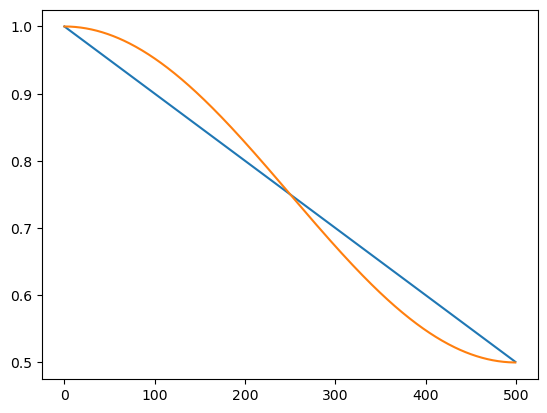

In [27]:
import matplotlib.pyplot as plt

plt.plot(epochs_space, teacher_forcing_ratio_linear)
plt.plot(epochs_space, teacher_forcing_ratio_cosine)